Hello! Here is some documented sample code that is executable (simply hit `shift enter` in each cell to run its contents).

I've included a piece of code that is tested and some visualisations...


# Stochastic charging algorithm for nanodust in planetary rings

## Brief rationale and background for the charging method
A nanograin’s charge varies stochastically with time and therefore in each timestep the number of electrons/ions collected by the grain must be estimated. The key currents of interest for dust in Saturn's main rings are summarised in the figure below:

<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/summary_currents_schematic.png width="350">

Instead of modelling the inter-arrival times of plasma particles using an exponential distribution (cf. [Cui & Goree
(1994)](https://doi.org/10.1109/27.279018) ), the Poisson distribution can be used to model the number of charged particles being collected by the grain in a given timestep. The type of particle is handled by the algorithm as described below, involving Poisson and binomial probability distributions and weighting the various currents appropriately.

## Theory
[Hsu et al. (2011)](https://doi.org/10.1029/2011JA016488) introduce a Poisson process approach, which is further developed in
the work of [Hsu et al. (2018)](https://doi.org/10.1126/science.aat3185). They developed their procedure independently of [Cui & Goree
(1994)](https://doi.org/10.1109/27.279018) but reach a similar approach. Their method can be summarised as 
    - (i) Generate a random number to determine how many events occur during the timestep using a Poisson probability distribution
    - (ii) Decide the type of charging events that occurs according to the relative strengths of the various currents.


For the plasma and photoemission currents ($I_i, I_e, I_\nu$), the expected number of charging events, $k_\alpha$, occurring between a time $t_n$ and $t_n + h$ (i.e. the rate, $\lambda_\alpha$) for a current of type $\alpha$ is
 
 \begin{equation}
 \lambda_\alpha = \int_{t_n}^{t_n + h} \frac{I_\alpha}{e} dt \quad \mathrm{for }\enspace \alpha=i, e, \nu,
 \label{eqn:lambdaAlpha}
 \end{equation}
 
 where the plasma ion ($i$) and plasma electron ($e$) currents are given by:
 
\begin{align}
		I_e \hspace{-3mm}&= I^{0}_{e} \text{exp}\left(\frac{e\phi_d}{k_\textrm{B}T_e}\right),\\
	 	I_i  \hspace{-3mm} &=I^{0}_{i} \left(1-\frac{Z_{i}e\phi_d}{k_\textrm{B}T_i}\right)
	 \text{ for }\phi_d<0, \text{ and } \\
		I_e  \hspace{-3mm} &= I^{0}_{e} \left(1 +\frac{e\phi_d}{k_\textrm{B}T_e}\right)   \\
		I_i  \hspace{-3mm} &= I^{0}_{i} \text{exp}\left(-\frac{Z_{i}e\phi_d}{k_\textrm{B}T_i}\right) 
	\text{ for }\phi_d \ge 0.
	\label{eqn:plasmacurrentsCui}
\end{align}

and the photo-electron emission current is given by:

\begin{equation}
I_\nu =
\begin{cases}
 \pi a_d^2 e f  & \mathrm{if} \enspace \phi < 0, \\
 \pi a_d^2 e f \text{exp}\left(-\frac{e\phi_d}{k_\textrm{B} T_\nu}\right) &\mathrm{if} \enspace \phi \geq 0, 
 \end{cases}
\label{eqn:photoemission}
\end{equation}

For the purposes of this notebook, the full details of the variables ($I^{0}_{e}, I^{0}_{i}, \phi_d, T_e, T_i, T_\nu, f  ...$) are not of importance (refer to thesis for more details).
 
 A random number is generated from a uniform distribution, $R_\textrm{P}^\alpha \sim U[0,1)$ and compared to the Poisson distribution for each current type,
 
 \begin{equation}
 P(\lambda_\alpha, k_\alpha) = \text{exp}(-\lambda_\alpha)\frac{\lambda_\alpha ^{k_\alpha}}{k_\alpha!}, \text{for } k_\alpha = 0,1,\ldots 
 \end{equation}

given a number of charging events $k_\alpha = 0,1,\ldots$.  So, for example, if $\lambda_\alpha = 0.4$ for a given current type (assuming a single current for simplicity) and the random number happens to be $R_\textrm{P}^\alpha=0.965$, then comparing to the corresponding probabilities:

 \begin{align}
 P(\lambda_\alpha &= 0.4, k_\alpha = 0) = 0.670\ldots,  \nonumber\\[-10pt]
 P(\lambda_\alpha &= 0.4, k_\alpha = 1) = 0.268\ldots, \nonumber\\[-10pt]
  P(\lambda_\alpha &= 0.4, k_\alpha = 2) = 0.0536\ldots, \nonumber \\[-10pt]
    P(\lambda_\alpha &= 0.4, k_\alpha = 3) = 0.00715\ldots, \label{eqn:PoissEG} \\[-10pt]
    \ldots \nonumber
 \end{align}
 
 which are illustrated in the figure below,
 **insert eg_numberline_poisson.png here ** 
where it can  be seen that the $k_\alpha=2$ event is chosen as $R_\textrm{P}^\alpha$ falls within that bin; that is, two charges happen to be collected by the grain during that timestep. The nature of the charges, whether electron or ion, depends on the current type in question; the way that the code developed here handles multiple current types is explained in greater detail below.

* Continue copying and pasting from thesis here *


* Explain about multiple current types here * by the figures <img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/eg_numberline_weightedbinomial.png  width="800"> 
and 
\ref{fig:multiIeg}.




## Charging code

### Single current example

The following snippet assumes $k = 3$ has been generated from the Poisson distribution for a single charging current. The aim is to work out how those 3 charging events are distributed in time across the step. The random numbers, `R`, in the following code cell have actually been set to specific values to check that the recursive tree walker behaves as expected (the expected result was worked out with pen and paper):

In [4]:
# Single current with R set at each level for checking purposes (rather than allowing randomness) 

import numpy as np
from scipy.stats import binom
from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py

def binomial_prob(N,R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        N = Number of charging events generated from Poisson distribution for full timestep
        R = Random number drawn from uniform probability distribution U[0,1] to compare to the binomial probabilities
    """
    # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
    #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
    print("binomial_prob R = ", R, "N = ", N)
    
    # Check where R falls in the Binomial probability distribution
    start_pt = 0.0 # define a variable to store the start point of probability distribution range
    k_ctr = 0
    end_pt = binom.pmf(k=k_ctr, n=N, p=0.5) # Define the end point for the first partition (for X = 0) using prob mass function to calculate binomial probability for k=0
    
    #print("Prob range for k = ", k_ctr, " is ", start_pt , "to ", end_pt )
    #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
    while ((R >= end_pt) and (k_ctr < N)): 
        k_ctr+=1 #increment to the next prob range
        start_pt = end_pt # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
        end_pt += binom.pmf(k=k_ctr, n=N , p=0.5)
        #print("Prob range for k = ", k_ctr, " is ", start_pt , "to ", end_pt )

    print("R lies in bin where k = ", k_ctr)
    return k_ctr

def walker(value, level=0, tree=Node(0)): 
    """
    Binary tree walker. Recursively splits timestep in half and keeps track of which level it is on, until the base case of k = 0 or 1 is reached.
    Inputs:
        value = number of charging events at a particular tree level
        level = depth of tree 
        tree = object to be printed for visual check
    """
    #np.random.seed(5*level-level) # make seed not constant with each recursive as otherwise the same splitting pattern will occur
    #np.random.seed(4-level)
    #np.random.seed(level+7)
    #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
    #print("walker R = ", R)
    
    # Print test (rather than allowing R to be random, choose R so that can check get the expected output)
    if level == 0:
        R = 0.548
    elif level == 1:
        R = 0.967
    elif level == 2:
        R = 0.873
    elif level == 3:
        R = 0.154
    elif level == 4:
        R = 0.223
    elif level == 5:
        R = 0.588
    else:
        R = 999999999999999999999 # I need to assign a UNUSED value to R, otherwise Python complains about R being referenced before assignment
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1 = binomial_prob(value, R) 
    substep2 = value - substep1 # The second substep is set by the first substep (number of charging events is conserved)

    # Define the left and child nodes:
    tree.left = Node(substep1)
    tree.right = Node(substep2)
    
    if value == 1 or value == 0: # base case (leaf nodes have no children)
        print("Base case")
        tree.left = None 
        tree.right = None
        return [(value, level)], tree # store the leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list
    
    a, tree_l = walker(substep1, level+1, tree.left) # recursive call to left child
    b, tree_r = walker(substep2, level+1, tree.right) # recursive call to right child
    
    print(f"walker level{level} called with value {value} splits into {substep1} and {substep2} as R = {R}")
    print(f" a = {a}, b = {b}")
    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a + b, tree #concatenate list (a+b) and also return tree

N_init = 3
lev = 0
leaf_nodes,tree = walker(N_init, level=lev, tree=Node(N_init))

print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print(tree)

# Use the results from the tree_walker to traverse a (toy dummy) step:
print("Traversing step")

delta_t = 1.0 # some arbitrary initial timestep size
t = 0.0 # dummy time variable 
Q = 0.0 # dummy charge variable
t_arr = [t]
Q_arr = [Q]

#for l in leaf_nodes:
    #print(leaf_nodes[0,:])
#    print("Charging event of ", l[0], "at level", l[1])
    #t = t + delta_t/2**l[1] #get t to traverse timestep and hence update appropriately according to binary tree output
    #Q = Q + Q_sub update charge at appropriate sub-intervals, based on binary tree output
    # Note I'll need to return the current step-size from the Runge-Kutta call
    
    
for (Q_sub, level) in leaf_nodes:
    print(f"Charging event of {Q_sub} at level {level}")
    t = t + delta_t/(2**level)
    Q = Q + Q_sub
    t_arr.append(t)
    Q_arr.append(Q)

print(f"Traversing step results, t = {t_arr }; Q = {Q_arr}")

binomial_prob R =  0.548 N =  3
R lies in bin where k =  2
binomial_prob R =  0.967 N =  2
R lies in bin where k =  2
binomial_prob R =  0.873 N =  2
R lies in bin where k =  2
binomial_prob R =  0.154 N =  2
R lies in bin where k =  0
binomial_prob R =  0.223 N =  0
R lies in bin where k =  0
Base case
binomial_prob R =  0.223 N =  2
R lies in bin where k =  0
binomial_prob R =  0.588 N =  0
R lies in bin where k =  0
Base case
binomial_prob R =  0.588 N =  2
R lies in bin where k =  1
binomial_prob R =  999999999999999999999 N =  1
R lies in bin where k =  1
Base case
binomial_prob R =  999999999999999999999 N =  1
R lies in bin where k =  1
Base case
walker level5 called with value 2 splits into 1 and 1 as R = 0.588
 a = [(1, 6)], b = [(1, 6)]
walker level4 called with value 2 splits into 0 and 2 as R = 0.223
 a = [(0, 5)], b = [(1, 6), (1, 6)]
walker level3 called with value 2 splits into 0 and 2 as R = 0.154
 a = [(0, 4)], b = [(0, 5), (1, 6), (1, 6)]
binomial_prob R =  0.154 N = 

### Multiple current example

*Explain theory here a bit*

Again, try a simple example, but this time because there are several types of current to account for, use appropriately weighted binomial distributions to assign probabilities:

In [1]:
#Stand-alone tree walking program (to traverse the binary tree)
# Multiple current with R set at each level for testing purposes (rather than allowing randomness) 

import numpy as np
from scipy.stats import binom
from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py
# Note that I've saved a backup of the current binarytree package source code in /Users⁩/mm9684⁩/Documents⁩/PhD_related⁩/binarytree-master_backup_from_github_joowani


def nodify(k):
    """
    Format charging events so can be printed nicely with binarytree's Node function
    """
    # Use a function to sort out the string concatenating and then transforming into a float
    # Node method cannot handle non-numbers so I need to hack a way to display the plasma electron, plasma ion, and photoelectron event numbers at each level
    # k = [k_e, k_i, k_nu]
    return float(str(k[0]) + "." + str(k[1]) + str(k[2]) ) # note that if k_e=1, k_i=2, k_nu = 0 then it will read as "1.2" rather than "1.20"


def binomial_prob_multiI(k_arr, R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        k_arr = Number of charging events generated from Poisson distributions for multiple current types for the full timestep
        R = Random number drawn from uniform probability distribution U[0,1] to compare to the binomial probabilities
    """
        
    # Multiple currents
    # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
    # I need to unpack the total number of charging events from the list passed into this function:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]

    #print(f"N_e = {N_e}, N_i = {N_i}, N_nu = {N_nu}")
    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        #print("In special case [1,1,1]")
        k_ctr = [99999999999999, 99999999999999, 99999999999999] # Initialize variable: use redonkulus value rather than NaN, otherwise Node() complains!
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        #print(f"In else clause, R = {R}")
        #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
        #print("binomial_prob R = ", R, "N = ", N)
        # Initialise 2-element array to store result for [I_e, I_i] number of charging events
        #k_ctr = [0, 0] # use zero rather than NaN, otherwise Node() complains!
        k_ctr=[99999999999999, 99999999999999, 99999999999999] # use an integer value that would get clearly flagged up if there's a bug in my code
        
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # First check whether it's an I_e type event:
        
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        if N_e == 1 and R < end_pt_e: 
            #print("In if N_e == 1")
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
            
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            #print("In while ((R >= end_pt_e) and (k_e_ctr < N_e)) ")
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
            #print("R=", R, "Prob range for k_e = ", k_e_ctr, " is ", start_pt_e , "to ", end_pt_e )
        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        #print(f"k_ctr = {k_ctr}")
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            #print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
                        
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i: 
                #print("In if N_i == 1")
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            #print(f"k_ctr = {k_ctr}")
            #print(f"start_pt_i = {start_pt_i}, end_pt_i = {end_pt_i}")
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                #print(f"In while ((R >= end_pt_i) and (k_i_ctr < N_i)) ")
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
            #print(f"k_ctr = {k_ctr}")
       ##print("and while_ctr = ", while_ctr)
       #print("R lies in bin where k = ", k_ctr)
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                #print("In if R > end_pt_e ")
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
               
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu: 
                    #print("In if N_nu == 1")
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)
                
                #print(f"k_ctr = {k_ctr}")
                #print(f"start_pt_nu = {start_pt_nu}, end_pt_nu = {end_pt_nu}")
                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    #print(f"In while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)) ")
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                    #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
                #print(f"k_ctr = {k_ctr}")
        
    return k_ctr

def walker(value_arr, level=0, tree=Node(0), level_1_switch=1): 
    """
    Binary tree walker. Recursively splits timestep in half and keeps track of which level it is on, until the base case of k = 0 or 1 is reached.
    Inputs:
        value = number of charging events at a particular tree level
        level = depth of tree 
        tree = object to be printed for visual check
        level_1_switch = switch to give deterministic output so results can be checked with theory
    """
        
    print("Inside walker()")
    # It was necessary to pass the level_1_switch to the walker() function explicitly for my unit test toy example
    
    if ( (value_arr[0]==1 and value_arr[1]==0 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 1 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 0 and value_arr[2]==1) or
        (value_arr[0]==0 and value_arr[1]==0 and value_arr[2]==0)): # base case (leaf nodes have no children)
        print("Base case")
        tree.left = None 
        tree.right = None
        return [(value_arr, level)], tree, level_1_switch # store the leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list
    
    print(f"level_1_switch = {level_1_switch}")
    #    # Unit test (rather than allowing R to be random, choose R so that can check get the expected output)
    if level == 0:
        #print("here 0 ")
        R = 0.47
    elif level == 1 and level_1_switch ==0 :
        R = 0.3
        level_1_switch = 1
    elif level_1_switch == 1 and level_1_switch ==1:
        R = 0.45
        level_1_switch = 0
    elif level == 2 and level_1_switch==0:
        R = 0.92
    elif level == 3:
        R = 0.1
    elif level == 4:
        R = 0.67
    elif level_1_switch == 1: # in order to make the code enter the level == 1 subblock twice, flip the switch on
        R = 0.45    #  there needs to be a double split happening at level 1, i.e. k_e = 2 needs to split as does k_e=1, k_i=2
    else:
        R = 1000 # I need to assign a UNUSED value to R, otherwise Python complains about R being referenced before assignment
   
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1_arr = binomial_prob_multiI(value_arr, R)  # value holds the list of [k_e, k_e] number of charging events
    #substep2_arr = np.array(value_arr) - np.array(substep1_arr) # Note that because value_arr is a numpy array as is substep1, I can do elementwise subtraction (ie treat the electron and ion counters separately)
    substep2_arr = [99999999999999,99999999999999,99999999999999] # intialise list (rather than mixing np array type)
    substep2_arr[0] = value_arr[0] - substep1_arr[0]
    substep2_arr[1] = value_arr[1] - substep1_arr[1]
    substep2_arr[2] = value_arr[2] - substep1_arr[2]

    print(f"LEVEL = {level} R={R},  substep1 = {substep1_arr}")
    #print(f"substep2 = {substep2_arr}")
    # Define the left and child nodes:
    tree.left = Node(nodify(substep1_arr)) # use my hacky nodify function as Node cannot handle non-numbers (e.g. arrays)
    tree.right = Node(nodify(substep2_arr))
    
    a_arr, tree_l, level_1_switch = walker(substep1_arr, level+1, tree.left, level_1_switch) # recursive call to left child
    b_arr, tree_r, level_1_switch = walker(substep2_arr, level+1, tree.right, level_1_switch) # recursive call to right child
    
    
    #print(f"walker level{level} called with value {value_arr} splits into {substep1_arr} and {substep2_arr} as R = {R}")
    #print(f" left subtree a_arr = {a_arr}, right subtree b_arr = {b_arr}")
    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a_arr + b_arr, tree, level_1_switch #concatenate list of lists (a_arr+b_arr) and also return tree


#N_init = [2,1] 
N_init = [3,2,0] # initialise k_e = 3, k_i = 2, k_nu=0
lev = 0
lev_1_switch = 0
leaf_nodes, tree, lev_1_switch = walker(N_init, level=lev, tree=Node(nodify(N_init)), level_1_switch=0)
print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print(tree)

# Use the results from the tree_walker to traverse a (toy dummy) step:
print("Traversing step")

delta_t = 1.0 # some arbitrary initial timestep size
t = 0.0 # dummy time variable 
Q = 0.0 # dummy charge variable
t_arr = [t]
Q_arr = [Q]
    
for (Q_sub, level) in leaf_nodes:
    print ("leaf_nodes: ", leaf_nodes)
    print(f"Charging event of {Q_sub} at level {level}")
    t = t + delta_t/(2**level)
    Q = Q - Q_sub[0] # "plasma electron current"
    Q = Q + Q_sub[1] # "plasma ion current"
    Q = Q + Q_sub[2] # "photoelectron current" (think it's in plus sense like plasma ion??)

    t_arr.append(t)
    Q_arr.append(Q)

print(f"Step results, t = {t_arr }; Q = {Q_arr}")

Inside walker()
level_1_switch = 0
LEVEL = 0 R=0.47,  substep1 = [2, 0, 0]
Inside walker()
level_1_switch = 0
LEVEL = 1 R=0.3,  substep1 = [1, 0, 0]
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
level_1_switch = 1
LEVEL = 1 R=0.45,  substep1 = [0, 0, 0]
Inside walker()
Base case
Inside walker()
level_1_switch = 0
LEVEL = 2 R=0.92,  substep1 = [0, 2, 0]
Inside walker()
level_1_switch = 0
LEVEL = 3 R=0.1,  substep1 = [0, 0, 0]
Inside walker()
Base case
Inside walker()
level_1_switch = 0
LEVEL = 4 R=0.67,  substep1 = [0, 1, 0]
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
Base case
Result:  [([1, 0, 0], 2), ([1, 0, 0], 2), ([0, 0, 0], 2), ([0, 0, 0], 4), ([0, 1, 0], 5), ([0, 1, 0], 5), ([1, 0, 0], 3)]

       _____3.2_____
      /             \
   _2.0_           _1.2_____________________
  /     \         /                         \
1.0     1.0     0.0            _____________1.2_
                              /                 \
              

Next, relax the deterministic setting of R:

In [2]:
# Script to check each possible tree outcome

import numpy as np
from scipy.stats import binom

from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py
# Note that I've saved a backup of the current binarytree package source code in /Users⁩/mm9684⁩/Documents⁩/PhD_related⁩/binarytree-master_backup_from_github_joowani
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # for legend labels
import sys

def nodify(k):
    # Use a function to sort out the string concatenating and then transforming into a float
    # Node method cannot handle non-numbers so I need to hack a way to display the plasma electron, plasma ion, and photoelectron event numbers at each level
    # k = [k_e, k_i, k_nu]
    return float(str(k[0]) + "." + str(k[1]) + str(k[2]) ) # note that if k_e=1, k_i=2, k_nu = 0 then it will read as "1.2" rather than "1.20"

def binomial_prob_multiI(k_arr, R):
     # Multiple currents
     # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
     # I need to unpack the total number of charging events from the list passed into this function:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]

    #print(f"N_e = {N_e}, N_i = {N_i}, N_nu = {N_nu}")
    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        #print("In special case [1,1,1]")
        k_ctr = [99999999999999, 99999999999999, 99999999999999] # Initialize variable: use redonkulus value rather than NaN, otherwise Node() complains!
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        #print(f"In else clause, R = {R}")
        #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
        #print("binomial_prob R = ", R, "N = ", N)
        # Initialise 2-element array to store result for [I_e, I_i] number of charging events
        #k_ctr = [0, 0] # use zero rather than NaN, otherwise Node() complains!
        k_ctr=[99999999999999, 99999999999999, 99999999999999] # use an integer value that would get clearly flagged up if there's a bug in my code
        
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # First check whether it's an I_e type event:
        
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        if N_e == 1 and R < end_pt_e: 
            #print("In if N_e == 1")
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
            
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            #print("In while ((R >= end_pt_e) and (k_e_ctr < N_e)) ")
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
            #print("R=", R, "Prob range for k_e = ", k_e_ctr, " is ", start_pt_e , "to ", end_pt_e )
        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        #print(f"k_ctr = {k_ctr}")
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            #print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
                        
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i: 
                #print("In if N_i == 1")
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            #print(f"k_ctr = {k_ctr}")
            #print(f"start_pt_i = {start_pt_i}, end_pt_i = {end_pt_i}")
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                #print(f"In while ((R >= end_pt_i) and (k_i_ctr < N_i)) ")
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
            #print(f"k_ctr = {k_ctr}")
       ##print("and while_ctr = ", while_ctr)
       #print("R lies in bin where k = ", k_ctr)
        
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                #print("In if R > end_pt_e ")
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
               
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu: 
                    #print("In if N_nu == 1")
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)
                
                #print(f"k_ctr = {k_ctr}")
                #print(f"start_pt_nu = {start_pt_nu}, end_pt_nu = {end_pt_nu}")
                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    #print(f"In while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)) ")
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                    #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
                #print(f"k_ctr = {k_ctr}")
        
    return k_ctr


def walker(value_arr, level=0, tree=Node(0)): 
    print("Inside walker()")
    # It was necessary to pass the level_1_switch to the walker() function explicitly for my unit test toy example
    
    if ( (value_arr[0]==1 and value_arr[1]==0 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 1 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 0 and value_arr[2]==1) or
        (value_arr[0]==0 and value_arr[1]==0 and value_arr[2]==0)): # base case (leaf nodes have no children)
        print("Base case")
        tree.left = None 
        tree.right = None
        return [(value_arr, level)], tree # store the leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list

    #np.random.seed(3*level+5)

    # Generate a random number from uniform prob distribution:
    R = np.random.uniform(low=0.0, high=1.0) 

    #print("Random number = ", R)
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1_arr = binomial_prob_multiI(value_arr, R)  # value holds the list of [k_e, k_e] number of charging events
    #substep2_arr = np.array(value_arr) - np.array(substep1_arr) # Note that because value_arr is a numpy array as is substep1, I can do elementwise subtraction (ie treat the electron and ion counters separately)
    substep2_arr = [99999999999999,99999999999999,99999999999999] # intialise list (rather than mixing np array type)
    substep2_arr[0] = value_arr[0] - substep1_arr[0]
    substep2_arr[1] = value_arr[1] - substep1_arr[1]
    substep2_arr[2] = value_arr[2] - substep1_arr[2]

    print(f"LEVEL = {level} R={R},  substep1 = {substep1_arr}")
    #print(f"substep2 = {substep2_arr}")
    # Define the left and child nodes:
    tree.left = Node(nodify(substep1_arr)) # use my hacky nodify function as Node cannot handle non-numbers (e.g. arrays)
    tree.right = Node(nodify(substep2_arr))
    
    a_arr, tree_l = walker(substep1_arr, level+1, tree.left) # recursive call to left child
    b_arr, tree_r = walker(substep2_arr, level+1, tree.right) # recursive call to right child
    
    #print(f"walker level{level} called with value {value_arr} splits into {substep1_arr} and {substep2_arr} as R = {R}")
    #print(f" left subtree a_arr = {a_arr}, right subtree b_arr = {b_arr}")
    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a_arr + b_arr, tree #concatenate list of lists (a_arr+b_arr) and also return tree


N_init = [4,2,3] #1 I_e charging event, 0 I_i charging events, 0 I_nu charging events
lev = 0
leaf_nodes, tree = walker(N_init, level=lev, tree=Node(nodify(N_init)))
print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print("\n Note that in the following tree, e.g. '4.23' means 4 plasma electron events, 2 plasma ion events, 3 photo-electron events")
print(" and e.g.'0.20' displays as '0.2' but still means 0 plasma electron events, 2 plasma ion events, 0 photo-electron events")

print(tree)

Inside walker()
LEVEL = 0 R=0.49033118258263153,  substep1 = [0, 0, 0]
Inside walker()
Base case
Inside walker()
LEVEL = 1 R=0.9107837805461518,  substep1 = [0, 0, 3]
Inside walker()
LEVEL = 2 R=0.9238470762868747,  substep1 = [0, 0, 3]
Inside walker()
LEVEL = 3 R=0.871397392659506,  substep1 = [0, 0, 2]
Inside walker()
LEVEL = 4 R=0.4563750158399571,  substep1 = [0, 0, 1]
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
LEVEL = 2 R=0.5185218439584408,  substep1 = [5, 0, 0]
Inside walker()
LEVEL = 3 R=0.014114835145904392,  substep1 = [0, 0, 0]
Inside walker()
Base case
Inside walker()
LEVEL = 4 R=0.4619128570679587,  substep1 = [2, 0, 0]
Inside walker()
LEVEL = 5 R=0.4465400339548453,  substep1 = [1, 0, 0]
Inside walker()
Base case
Inside walker()
Base case
Inside walker()
LEVEL = 5 R=0.8809309636490104,  substep1 = [3, 0, 0]
Inside walker()
LEVEL = 6 R=0.9879676365783909,  substep1 = [3, 0, 0]
Inside walker()
LEVE


### Unit test

In addition to using print statements to check the code, it was checked more thoroughly using `pytest`, for example:

In [5]:
import ipytest
ipytest.autoconfig()


AttributeError: module 'ipytest' has no attribute 'autoconfig'

In [6]:
%%run_pytest[clean]

# Run pytest to check that my stochastic charging algorithm for I_e, I_i, I_nu currents is working as expected
# Test cases defined in the pytest.mark.parametrize() call were worked out using pen and paper
# To run the tests, decorate the cell containing the tests with the %%run_pytest[clean] magic

import pytest
#import sys

# Test binomial prob function stand-alone
# For 3 currents (as opposed to 2), the main difference is that I need to introduce a 3rd element to my k_ctr array, 
 #  in order to store the photoemission current's number of charging events too

from scipy.stats import binom

# I'll need to use pytest.mark.parametrize decorator (because I need to pass multiple test arguments to binomial_prob_multiI() function)

def binomial_prob_multiI(k_arr, R):
    # Multiple currents
    # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
    
    # Unpack the total number of charging events from the list passed into this function, to more obvious variable-name, number N:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]
    
    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        k_ctr = [9999, 9999, 9999] # Initialize variable: use redonkulus value rather than NaN so that a bug would be obviously apparent
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        # Initialise 2-element array to store result for [I_e, I_i] number of charging events
        k_ctr=[9999, 9999, 9999] # use an integer value that would get clearly flagged up if there's a bug in my code
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # First check whether it's an I_e type event:
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        if N_e == 1 and R < end_pt_e:
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
        
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            ##print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i:
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
   
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability     for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu:
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)

                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
                
    return k_ctr

# Define some test cases
@pytest.mark.parametrize("k_arr, R, expect", [
    ([1,1,1], 0.0,[1,0,0]),
    ([1,1,1], 0.3,[1,0,0]),
    ([1,1,1], 1/3.0, [1,0,0]),
    ([1,1,1], 0.4, [0,1,0]),
    ([1,1,1], 0.6, [0,1,0]),
    ([1,1,1], 0.7, [0,0,1]),
    ([1,1,1], 0.99, [0,0,1]),
    ([1,2,3], 0.0, [1,0,0]),
    ([1,2,3], 0.15, [1,0,0]),
    ([1,2,3], 1/6., [1,0,0]),
    ([1,2,3], 0.2, [0,0,0]),
    ([1,2,3], 0.24, [0,0,0]),
    ([1,2,3], 0.3, [0,1,0]),
    ([1,2,3], 0.41, [0,1,0]),
    ([1,2,3], 0.42, [0,2,0]),
    ([1,2,3], 0.49, [0,2,0]),
    ([1,2,3], 0.51, [0,0,0]),
    ([1,2,3], 0.56, [0,0,0]),
    ([1,2,3], 0.57, [0,0,1]),
    ([1,2,3], 0.74, [0,0,1]),
    ([1,2,3], 0.76, [0,0,2]),
    ([1,2,3], 0.93, [0,0,2]),
    ([1,2,3], 0.94, [0,0,3]),
    ([1,2,3], 0.99, [0,0,3]),
    ([2,1,1], 0.1, [0,0,0]),
    ([2,1,1], 0.3, [1,0,0]),
    ([2,1,1], 0.4, [2,0,0]),
    ([2,1,1], 0.49, [2,0,0]),
    ([2,1,1], 0.6, [0,1,0]),
    ([2,1,1], 0.7, [0,1,0]),
    ([2,1,1], 0.76, [0,0,1]),
    ([2,1,1], 0.9, [0,0,1]),
    ([1,3,1], 0.01, [1,0,0]),
    ([1,3,1], 0.19, [1,0,0]),
    ([1,3,1], 0.21, [0,0,0]),
    ([1,3,1], 0.27, [0,0,0]),
    ([1,3,1], 0.28, [0,1,0]), 
    ([1,3,1], 0.48, [0,1,0]),
    ([1,3,1], 0.51, [0,2,0]),
    ([1,3,1], 0.71, [0,2,0]),
    ([1,3,1], 0.48, [0,1,0]),
    ([1,3,1], 0.51, [0,2,0]),
    ([1,3,1], 0.71, [0,2,0]),
    ([1,3,1], 0.73, [0,3,0]),
    ([1,3,1], 0.79, [0,3,0]),
    ([1,3,1], 0.81, [0,0,1]),
    ([1,3,1], 0.99, [0,0,1]),
    ([1,1,2], 0.10, [1,0,0]),
    ([1,1,2], 0.24, [1,0,0]),
    ([1,1,2], 0.26, [0,1,0]),
    ([1,1,2], 0.49, [0,1,0]),
    ([1,1,2], 0.51, [0,0,0]),
    ([1,1,2], 0.62, [0,0,0]),
    ([1,1,2], 0.63, [0,0,1]),
    ([1,1,2], 0.87, [0,0,1]),
    ([1,1,2], 0.88, [0,0,2]),
    ([1,1,2], 0.99, [0,0,2]),
    ([2,3,1], 0.01, [0,0,0]),
    ([2,3,1], 0.08, [0,0,0]),
    ([2,3,1], 0.09, [1,0,0]),
    ([2,3,1], 0.24, [1,0,0]),
    ([2,3,1], 0.26, [2,0,0]),
    ([2,3,1], 0.33, [2,0,0]),
    ([2,3,1], 0.34, [0,0,0]),
    ([2,3,1], 0.39, [0,0,0]),
    ([2,3,1], 0.40, [0,1,0]),
    ([2,3,1], 0.58, [0,1,0]),
    ([2,3,1], 0.59, [0,2,0]),
    ([2,3,1], 0.76, [0,2,0]),
    ([2,3,1], 0.78, [0,3,0]),
    ([2,3,1], 0.82, [0,3,0]),
    ([2,3,1], 0.84, [0,0,1]),
    ([2,3,1], 0.99, [0,0,1]),
    ([3,1,2], 0.01, [0,0,0]),
    ([3,1,2], 0.06, [0,0,0]),
    ([3,1,2], 0.07, [1,0,0]),
    ([3,1,2], 0.24, [1,0,0]),
    ([3,1,2], 0.26, [2,0,0]),
    ([3,1,2], 0.43, [2,0,0]),
    ([3,1,2], 0.44, [3,0,0]),
    ([3,1,2], 0.49, [3,0,0]),
    ([3,1,2], 0.51, [0,1,0]),
    ([3,1,2], 0.60, [0,1,0]),
    ([3,1,2], 0.67, [0,0,0]),
    ([3,1,2], 0.70, [0,0,0]),
    ([3,1,2], 0.76, [0,0,1]),
    ([3,1,2], 0.91, [0,0,1]),
    ([3,1,2], 0.92, [0,0,2]),
    ([3,1,2], 0.99, [0,0,2]),
    ([1,3,2], 0.01, [1,0,0]),
    ([1,3,2], 0.16, [1,0,0]),
    ([1,3,2], 0.17, [0,0,0]),
    ([1,3,2], 0.22, [0,0,0]),
    ([1,3,2], 0.23, [0,1,0]),
    ([1,3,2], 0.40, [0,1,0]),
    ([1,3,2], 0.42, [0,2,0]),
    ([1,3,2], 0.60, [0,2,0]),
    ([1,3,2], 0.61, [0,3,0]),
    ([1,3,2], 0.66, [0,3,0]),
    ([1,3,2], 0.67, [0,0,0]),
    ([1,3,2], 0.74, [0,0,0]),
    ([1,3,2], 0.76, [0,0,1]),
    ([1,3,2], 0.90, [0,0,1]),
    ([1,3,2], 0.92, [0,0,2]),
    ([1,3,2], 0.99, [0,0,2]),
    ([3,0,2], 0.01, [0,0,0]),
    ([3,0,2], 0.07, [0,0,0]),
    ([3,0,2], 0.08, [1,0,0]),
    ([3,0,2], 0.28, [1,0,0]),
    ([3,0,2], 0.31, [2,0,0]),
    ([3,0,2], 0.51, [2,0,0]),
    ([3,0,2], 0.53, [3,0,0]),
    ([3,0,2], 0.59, [3,0,0]),
    ([3,0,2], 0.61, [0,0,0]),
    ([3,0,2], 0.69, [0,0,0]),
    ([3,0,2], 0.71, [0,0,1]),
    ([3,0,2], 0.89, [0,0,1]),
    ([3,0,2], 0.91, [0,0,2]),
    ([3,0,2], 0.99, [0,0,2]),
    ([0,2,3], 0.01, [0,0,0]),
    ([0,2,3], 0.09, [0,0,0]),
    ([0,2,3], 0.11, [0,1,0]),
    ([2,3,1], 0.40, [0,1,0]),
    ([2,3,1], 0.58, [0,1,0]),
    ([2,3,1], 0.59, [0,2,0]),
    ([2,3,1], 0.76, [0,2,0]),
    ([2,3,1], 0.78, [0,3,0]),
    ([2,3,1], 0.82, [0,3,0]),
    ([2,3,1], 0.84, [0,0,1]),
    ([2,3,1], 0.99, [0,0,1]),
    ([3,1,2], 0.01, [0,0,0]),
    ([3,1,2], 0.06, [0,0,0]),
    ([3,1,2], 0.07, [1,0,0]),
    ([3,1,2], 0.24, [1,0,0]),
    ([3,1,2], 0.26, [2,0,0]),
    ([3,1,2], 0.43, [2,0,0]),
    ([3,1,2], 0.44, [3,0,0]),
    ([3,1,2], 0.49, [3,0,0]),
    ([3,1,2], 0.51, [0,1,0]),
    ([3,1,2], 0.60, [0,1,0]),
    ([3,1,2], 0.67, [0,0,0]),
    ([3,1,2], 0.70, [0,0,0]),
    ([3,1,2], 0.76, [0,0,1]),
    ([3,1,2], 0.91, [0,0,1]),
    ([3,1,2], 0.92, [0,0,2]),
    ([3,1,2], 0.99, [0,0,2]),
    ([1,3,2], 0.01, [1,0,0]),
    ([1,3,2], 0.16, [1,0,0]),
    ([1,3,2], 0.17, [0,0,0]),
    ([1,3,2], 0.22, [0,0,0]),
    ([1,3,2], 0.23, [0,1,0]),
    ([1,3,2], 0.40, [0,1,0]),
    ([1,3,2], 0.42, [0,2,0]),
    ([1,3,2], 0.60, [0,2,0]),
    ([1,3,2], 0.61, [0,3,0]),
    ([1,3,2], 0.66, [0,3,0]),
    ([1,3,2], 0.67, [0,0,0]),
    ([1,3,2], 0.74, [0,0,0]),
    ([1,3,2], 0.76, [0,0,1]),
    ([1,3,2], 0.90, [0,0,1]),
    ([1,3,2], 0.92, [0,0,2]),
    ([1,3,2], 0.99, [0,0,2]),
    ([3,0,2], 0.01, [0,0,0]),
    ([3,0,2], 0.07, [0,0,0]),
    ([3,0,2], 0.08, [1,0,0]),
    ([3,0,2], 0.28, [1,0,0]),
    ([3,0,2], 0.31, [2,0,0]),
    ([3,0,2], 0.51, [2,0,0]),
    ([3,0,2], 0.53, [3,0,0]),
    ([3,0,2], 0.59, [3,0,0]),
    ([3,0,2], 0.61, [0,0,0]),
    ([3,0,2], 0.69, [0,0,0]),
    ([3,0,2], 0.71, [0,0,1]),
    ([3,0,2], 0.89, [0,0,1]),
    ([3,0,2], 0.91, [0,0,2]),
    ([3,0,2], 0.99, [0,0,2]),
    ([0,2,3], 0.01, [0,0,0]),
    ([0,2,3], 0.09, [0,0,0]),
    ([0,2,3], 0.11, [0,1,0]),
    ([0,2,3], 0.29, [0,1,0]),
    ([0,2,3], 0.31, [0,2,0]),
    ([0,2,3], 0.39, [0,2,0]),
    ([0,2,3], 0.41, [0,0,0]),
    ([0,2,3], 0.47, [0,0,0]),
    ([0,2,3], 0.48, [0,0,1]),
    ([0,2,3], 0.69, [0,0,1]),
    ([0,2,3], 0.71, [0,0,2]),
    ([0,2,3], 0.92, [0,0,2]),
    ([0,2,3], 0.93, [0,0,3]),
    ([0,2,3], 0.99, [0,0,3]),
    ([2,3,0], 0.01, [0,0,0]),
    ([2,3,0], 0.09, [0,0,0]),
    ([2,3,0], 0.11, [1,0,0]),
    ([2,3,0], 0.29, [1,0,0]),
    ([2,3,0], 0.31, [2,0,0]),
    ([2,3,0], 0.39, [2,0,0]),
    ([2,3,0], 0.41, [0,0,0]),
    ([2,3,0], 0.47, [0,0,0]),
    ([2,3,0], 0.48, [0,1,0]),
    ([2,3,0], 0.69, [0,1,0]),
    ([2,3,0], 0.71, [0,2,0]),
    ([2,3,0], 0.92, [0,2,0]),
    ([2,3,0], 0.93, [0,3,0]),
    ([2,3,0], 0.99, [0,3,0]),
    ([2,2,2], 0.01, [0,0,0]),
    ([2,2,2], 0.08, [0,0,0]),
    ([2,2,2], 0.09, [1,0,0]),
    ([2,2,2], 0.24, [1,0,0]),
    ([2,2,2], 0.26, [2,0,0]),
    ([2,2,2], 0.31, [2,0,0]),
    ([2,2,2], 0.34, [0,0,0]),
    ([2,2,2], 0.41, [0,0,0]),
    ([2,2,2], 0.42, [0,1,0]),
    ([2,2,2], 0.58, [0,1,0]),
    ([2,2,2], 0.59, [0,2,0]),
    ([2,2,2], 0.66, [0,2,0]),
    ([2,2,2], 0.67, [0,0,0]),
    ([2,2,2], 0.74, [0,0,0]),
    ([2,2,2], 0.76, [0,0,1]),
    ([2,2,2], 0.91, [0,0,1]),
    ([2,2,2], 0.93, [0,0,2]),
    ([2,2,2], 0.99, [0,0,2]),
    ([1,1,0], 0.010, [1,0,0]),
    ([1,1,0], 0.200, [1,0,0]),
    ([1,1,0], 0.490, [1,0,0]),
    ([1,1,0], 0.510, [0,1,0]),
    ([1,1,0], 0.830, [0,1,0]),
    ([1,1,0], 0.959, [0,1,0]),
    ([0,1,1], 0.010, [0,1,0]),
    ([0,1,1], 0.200, [0,1,0]),
    ([0,1,1], 0.490, [0,1,0]),
    ([0,1,1], 0.510, [0,0,1]),
    ([0,1,1], 0.830, [0,0,1]),
    ([0,1,1], 0.959, [0,0,1]),
    ([1,0,1], 0.010, [1,0,0]),
    ([1,0,1], 0.200, [1,0,0]),
    ([1,0,1], 0.490, [1,0,0]),
    ([1,0,1], 0.510, [0,0,1]),
    ([1,0,1], 0.830, [0,0,1]),
    ([1,0,1], 0.959, [0,0,1]),
    ([1,1,1], 0.010, [1,0,0]),
    ([1,1,1], 0.290, [1,0,0]),
    ([1,1,1], 0.340, [0,1,0]),
    ([1,1,1], 0.650, [0,1,0]),
    ([1,1,1], 0.670, [0,0,1]),
    ([1,1,1], 0.999, [0,0,1]),
    ([4,0,0], 0.010, [0,0,0]),
    ([4,0,0], 0.060, [0,0,0]),
    ([4,0,0], 0.065, [1,0,0]),
    ([4,0,0], 0.310, [1,0,0]),
    ([4,0,0], 0.320, [2,0,0]),
    ([4,0,0], 0.680, [2,0,0]),
    ([4,0,0], 0.690, [3,0,0]),
    ([4,0,0], 0.930, [3,0,0]),
    ([4,0,0], 0.940, [4,0,0]),
    ([4,0,0], 0.999, [4,0,0]),
    ([0,3,0], 0.010, [0,0,0]),
    ([0,3,0], 0.120, [0,0,0]),
    ([0,3,0], 0.130, [0,1,0]),
    ([0,3,0], 0.490, [0,1,0]),
    ([0,3,0], 0.510, [0,2,0]),
    ([0,3,0], 0.870, [0,2,0]),
    ([0,3,0], 0.880, [0,3,0]),
    ([0,3,0], 0.999, [0,3,0]),    
    ([0,0,2], 0.01, [0,0,0]),
    ([0,0,2], 0.24, [0,0,0]),
    ([0,0,2], 0.26, [0,0,1]),
    ([0,0,2], 0.74, [0,0,1]),
    ([0,0,2], 0.76, [0,0,2]),
    ([0,0,2], 0.99, [0,0,2]),
    ([0,1,2], 0.01, [0,1,0]),
    ([0,1,2], 0.32, [0,1,0]),
    ([0,1,2], 0.34, [0,0,0]),
    ([0,1,2], 0.49, [0,0,0]),
    ([0,1,2], 0.51, [0,0,1]),
    ([0,1,2], 0.83, [0,0,1]),
    ([0,1,2], 0.84, [0,0,2]),
    ([0,1,2], 0.99, [0,0,2]),
    ([1,0,0], 0.01, [1,0,0]),
    ([1,0,0], 0.24, [1,0,0]),
    ([1,0,0], 0.49, [1,0,0]),
    ([1,0,0], 0.51, [1,0,0]),
    ([1,0,0], 0.63, [1,0,0]),
    ([1,0,0], 0.79, [1,0,0]),
    ([1,0,0], 0.99, [1,0,0]),
    ([0,1,0], 0.01, [0,1,0]),
    ([0,1,0], 0.24, [0,1,0]),
    ([0,1,0], 0.49, [0,1,0]),
    ([0,1,0], 0.51, [0,1,0]),
    ([0,1,0], 0.63, [0,1,0]),
    ([0,1,0], 0.79, [0,1,0]),
    ([0,1,0], 0.99, [0,1,0]),
    ([0,0,1], 0.01, [0,0,1]),
    ([0,0,1], 0.24, [0,0,1]),
    ([0,0,1], 0.49, [0,0,1]),
    ([0,0,1], 0.51, [0,0,1]),
    ([0,0,1], 0.63, [0,0,1]),
    ([0,0,1], 0.79, [0,0,1]),
    ([0,0,1], 0.99, [0,0,1]),    
])

def test_binomial_prob_multiI(k_arr, R, expect):
    output = binomial_prob_multiI(k_arr, R)
    assert output == expect
    
print("Testing")

UsageError: Cell magic `%%run_pytest[clean]` not found.


### Batch test
The algorithm can be further tested thousands of times by running the following:

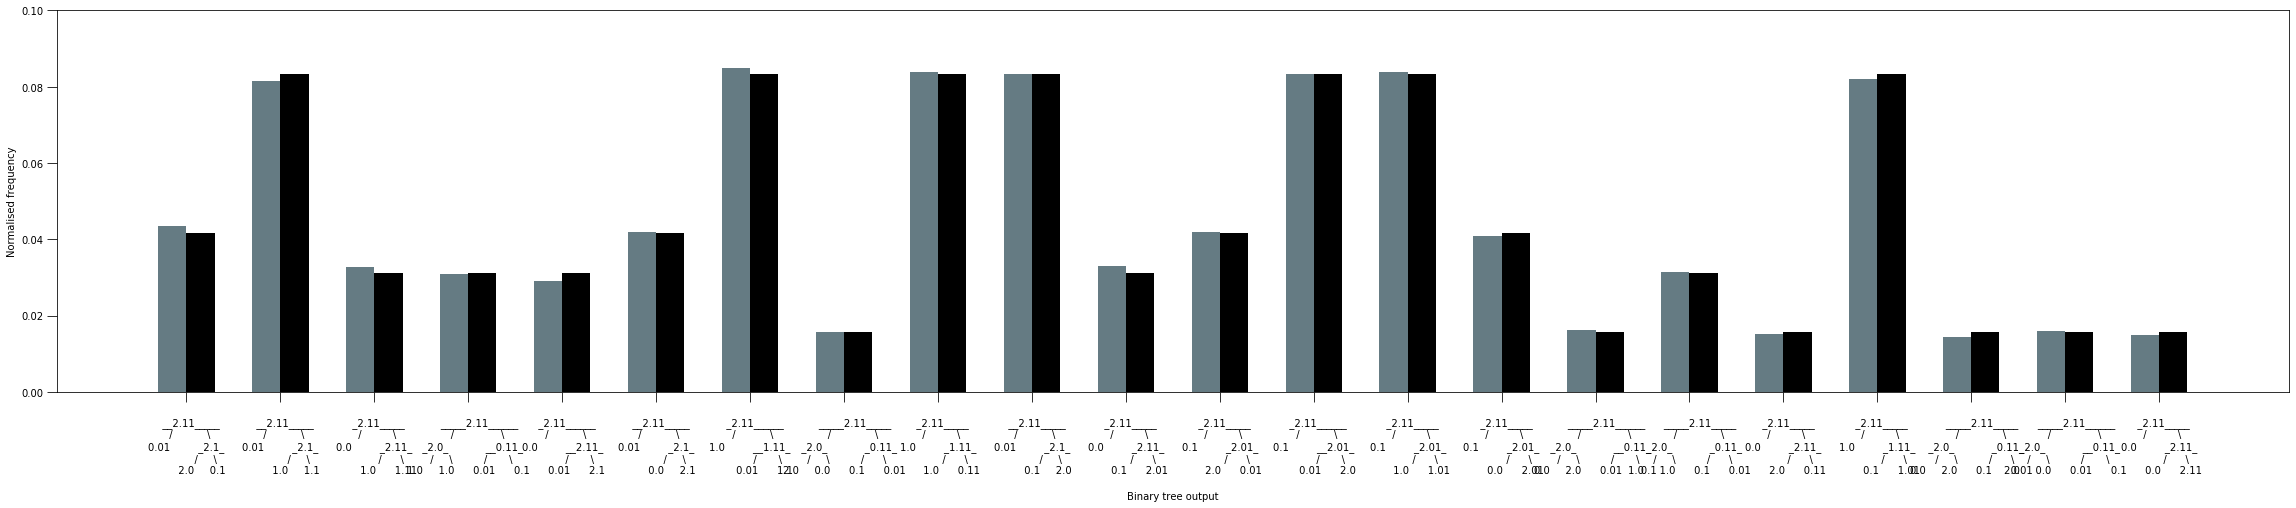

In [1]:
# Call a script that contains the code which outputs a binary tree based on binomial probabilities 
# Note that this only works out the predicted probs for k_initial = [k_e, k_i, k_nu]= [2,1,1] up to level 1 or 2
%matplotlib inline
import matplotlib.pyplot as plt
 
%run ./binarytree_binomial_IeIiInu_sample_batch.py --k_e_init=2 --k_i_init=1 --k_nu_init=1 --level_lim=2 --N_runs=50000

plt.show()

Once the algorithm has been run a sufficiently large number of times (more than a few 10,000s), the grey (left hand) bars match the black (right hand) bars.

That's probably enough testing for the moment! 


## A bit of data visualisation

### Bokeh

Here's an example interactive visualisation for a 6.4GB output file using Dask (with parquet files), for a simulation assuming a constant charge-to-mass ratio, which I prepared earlier - I don't think Dask would behave well on binderhub (as it would need to access multiple cores), so I provide the plot only: http://www.star.bris.ac.uk/macespace/bokeh_testplot2.html 

### Ephemerides

Early on in my PhD, I did some stuff with JPL's HORIZONS ephemerides database to visualise where moons were located in relation to rings at different times:

In [ ]:
# Plot out the more than one moon's trajectories for a test observation date

# Test on Janus & Epimetheus and compare to plot above 
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import pandas as pd
import numpy as np
#from IPython.display import display
import callhorizons
from datetime import datetime
from datetime import timedelta

def calcInputParams_set_epochrange(startEpoch_str, orb_period):
    # Inputs: starting date and time (%Y-%b-%d %H:%M) as string, orbital periods obtained earlier using HORIZONS and recorded in dict
    
    orb_period = (orb_period*1.004)*24*60*60 # add a little bit of time (0.4% T) on so orbit closes and convert to seconds 
    # Convert string to datetime object
    startEpoch_dt = datetime.strptime(startEpoch_str,"%Y-%b-%d %H:%M")
    # As I want to plot out a single trajectory, I need a period's worth of data
    stopEpoch_dt = startEpoch_dt + timedelta(seconds = orb_period)             
    stepSize = orb_period/100.0 # rule-of-thumb
    # Convert to minutes and round down 
    stepSize/=60
    stepSize = np.floor(stepSize)
    # Convert to the datetime format accepted by callhorizons and convert to string:
    #print("here")
    stopEpoch_str = str((datetime.strptime(str(stopEpoch_dt), "%Y-%m-%d %H:%M:%S.%f").strftime("%Y-%b-%d %H:%M")))
    ##stopEpoch_dt = datetime.strptime(str(stopEpoch_dt),"%Y-%m-%d %H:%M:%S.%f") # convert to string
    print("Start: ", startEpoch_str, "Stop: ", stopEpoch_str, "step: ", stepSize)        
    return(stopEpoch_str, int(stepSize)) # returns (str, int)          

def callHorizonsQuery_returnLists(StartDate, StopDate, MoonID, stepSize): 
    """
    This function returns the datetime, targetname and coordinates of the Moon in km
    Note the StopDate and stepSize are returned from calcInputParams_set_epochrange()
    If this python errors then useful msgs can be found by clicking on the outputted url 
    """
    print("-"*50)
    vec = callhorizons.query(targetname=MoonID,  smallbody=False)  # 618 = Pan
    vec.set_epochrange(start_epoch=StartDate, stop_epoch=StopDate, step_size=(str(stepSize)+"m") ) # ~ 1/100th of orbital period in minutes
    (vec.get_vectors(center = "500@6"), 'epochs queried') #6 = Saturn barycentre
    #print("Inside func:", vec['targetname'], vec['datetime'][0], vec['datetime_jd'][0], vec['x'][0], vec['y'][0], vec['z'][0]) # Extract the first element, ie discard all other times after StartDate
    return(vec['datetime'], vec['targetname'], vec['x'], vec['y'] ) #array 

# Initialise the variables :
## Orbital period stuff (obtained from callhorizons):
orb_periods_dict = {"Pan":0.5750, "Daphnis":np.NaN, "Atlas":0.6019, "Prometheus":0.612986, "Pandora":0.628804,
             "Epimetheus": 0.694590, "Janus":0.694590, "Aegaeon": np.NaN, "Mimas":0.9424218, "Methone":np.NaN,
             "Anthe":np.NaN, "Pallene":np.NaN, "Enceladus":1.370218, "Tethys":1.888, "Telesto":1.887802,
             "Calypso":1.887802, "Polydeuces":np.NaN, "Dione":2.736915, "Helene":2.736915, "Rhea":4.518}#,
             #"Titan":15.945421, "Hyperion": 21.276609} #, "Iapetus":79.33}#, "Phoebe":550.31}# in days
# Use the data from NASA's Saturnian Satellite Fact Sheet to fill in the NaNs:
orb_periods_dict["Daphnis"] = 0.594 # in days
orb_periods_dict["Aegaeon"] = 0.8081
orb_periods_dict["Methone"] = 1.01
orb_periods_dict["Anthe"] = 1.04
orb_periods_dict["Pallene"] = 1.14
orb_periods_dict["Polydeuces"] = 2.74

# NAIF body IDs:
moon_ID_dict = {"Pan":"618", "Daphnis":"635", "Atlas":"615", "Prometheus":"616", "Pandora":"617",
             "Epimetheus": "611", "Janus":"610", "Aegaeon": "653", "Mimas":"601", "Methone":"632",
             "Anthe":"649", "Pallene":"633", "Enceladus":"602", "Tethys":"603", "Telesto":"613",
             "Calypso":"614", "Polydeuces":"634", "Dione":"604", "Helene":"612", "Rhea":"605"}#,
             #"Titan":"606", "Hyperion": "607"}#, "Iapetus":"608"}#, "Phoebe":"609"}

start_date = "1980-Nov-12 00:00" # Earliest recorded date for spacecraft observation of spokes

## Setup the plotting figure :
fig, ax = plt.subplots(figsize=(10,10)) #OOP approach -> store figure & axis references to the newly created subplots instance
# Draw on Saturn:
sat_R = 58232 # Saturn's radius in km
saturn_circ = Circle((0,0), radius=sat_R, color="#edcb23")
ax.add_artist(saturn_circ)
# Draw on main rings
Aring = Wedge(center=(0, 0),r=136775, theta1=0, theta2=360, width=14605, color="#b5b9bf", alpha=0.5) # A ring spans 122,170 – 136,775 km
Bring = Wedge(center=(0, 0),r=117580, theta1=0, theta2=360, width=25580, color="#b5b9bf", alpha=0.5) # B ring spans 92,000   –  117,580 km
Cring = Wedge(center=(0, 0),r=92000, theta1=0, theta2=360, width=17342, color="#b5b9bf", alpha=0.5) # C ring spans 74,658 – 92,000 km
Dring = Wedge(center=(0, 0),r=74510, theta1=0, theta2=360, width=7610, color="#b5b9bf", alpha=0.5) # D ring spands 66,900   –  74,510 km

ax.add_artist(Aring)
ax.add_artist(Bring)
ax.add_artist(Cring)
ax.add_artist(Dring)

# Mark on radial position where Keplerian orbital period is 1 day
kep_oneDay_R = ( ((6.67e-11*5.68e26)*(24*60*60)**2)/(4*np.pi**2) )**(1.0/3.0) #in metres
kepPeriodOneDay = Circle((0,0), radius=kep_oneDay_R/1000.0, color="k", fill=None, linestyle="--", lw = 2)
ax.add_artist(kepPeriodOneDay)
# Mark on synchronous orbit
synch_R = ( ((6.67e-11*5.68e26)*(10.65*60*60)**2)/(4*np.pi**2) )**(1.0/3.0) #in metres. Use Jonof-Hutter's Saturn rotation period of 10h39m
synchOrbit = Circle((0,0), radius=synch_R/1000.0, color="b", fill=None, linestyle="--", lw = 2)
ax.add_artist(synchOrbit)

# Sort out axes' labels
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
# Set axis limits based on outermost moon's sma
ax.set_xlim(-5.5e5, 5.5e5) 
ax.set_ylim(-5.5e5, 5.5e5)

# Loop through moons:
for moonkey in moon_ID_dict:
    # calculate the input parameters for the .set_epochrange call in callHorizonsQuery_returnLists()
    (stop_date, step) = calcInputParams_set_epochrange(start_date, orb_periods_dict[moonkey])
    moon_id = moon_ID_dict[moonkey]
    # call the function for each row and unpack into appropriately named new columns
    (datetime_list, targetname_list, xCoord_list, yCoord_list) = callHorizonsQuery_returnLists(start_date, stop_date, moon_id, step) 
    print("The relevant lists have been returned...")
    # Draw on the orbital trajectory:
    line=ax.plot(xCoord_list, yCoord_list,"-", label=moonkey)
    # Label orbits:
    ax.text(x=xCoord_list[0] ,y=yCoord_list[0] , s=moonkey, color = line[0].get_color() )
    # Next use circular marker to show moon's position at the time (ie start_date) specified on the plot's title
    ax.plot(xCoord_list[0],yCoord_list[0], "o", color = line[0].get_color())
    
plt.title(start_date)    
plt.show()
